<a id='1.1'></a>
### 1.1 Start Hadoop

Start Hadoop

Open a terminal and execute
```sh
hadoop-start.sh
```

<a id='1.2'></a>
### 1.2 Search for Spark Installation 
This step is required just because we are working in the course environment.

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
print ("Scope 3 Emission Analysis")
print ("--")
print ("Analysis initialization:")
print ("  1. Building the Spark Session...")

Scope 3 Emission Analysis
--
Analysis initialization:
  1. Building the Spark Session...


I'm changing pandas max column width property to improve data displaying

<a id='1.3'></a>
### 1.3 Create SparkSession

By setting this environment variable we can include extra libraries in our Spark cluster.<br/>
GraphFrames is not in spark core so we have to add it this way

In [2]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "graphframes:graphframes:0.8.2-spark3.2-s_2.12" --jars /opt/hive3/lib/hive-hcatalog-core-3.1.2.jar pyspark-shell'

The first thing always is to create the SparkSession

In [3]:
# 1. Building the Spark Session
sc = SparkSession.builder\
    .master('local')\
    .appName('Scope3')\
    .getOrCreate()
spark = SparkSession(sc)

Ivy Default Cache set to: /home/osbdet/.ivy2/cache
The jars for the packages stored in: /home/osbdet/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-99fd1f3e-19c4-4752-b2c6-ecb7e4c86950;1.0
	confs: [default]


:: loading settings :: url = jar:file:/opt/spark3/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 96ms :: artifacts dl 2ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-99fd1f3e-19c4-4752-b2c6-ecb7e4c86950
	confs: [default]
	0 artifacts copied, 2 already retrieved (0kB/2ms)
22/10/23 14:49:11 ERROR SparkContext: Failed to add file:/opt/hive3/lib/hive-hcatalog-c

<a id='2'></a>
## 2. Lab

<a id='2.1'></a>
### 2.1 Check Lab Files

In order to complete this lab you need to previosly upload the datasets into HDFS.<br/>

Check you have the data ready in HDFS

http://localhost:50070/explorer.html#/datalake/raw/san-francisco-bay-bike-sharing/stations/

http://localhost:50070/explorer.html#/datalake/raw/san-francisco-bay-bike-sharing/trips/


<a id='2.2'></a>
### 2.2 Create the DataFrames

The first step after creating the SparkSession is to create one or more DataFrames<br/>

In [4]:
# 2. Dataframes creation
print ("  2. Creating the vertices (Sites) and edges (trips) DataFrames from HDFS...")
stations = (spark.read
        .option("header","true")
        .option("inferSchema","true")
        .csv("hdfs://localhost:9000/datalake/raw/scope3",sep=";")
        .limit(10000)
        .distinct())
# trips = (spark.read
#               .option("header","true")
#               .option("inferSchema","true") 
#               .csv("hdfs://localhost:9000/datalake/raw/san-francisco-bay-bike-sharing/trips/"))

  2. Creating the vertices (Sites) and edges (trips) DataFrames from HDFS...


In [5]:
stations.limit(5).toPandas()

,_c0,Origin_Key,Origin_Postal_Code,Origin_City,Origin_Country,Origin_Country_Name,Origin_Region,Origin_Plant,Target_Key,Target_Postal_Code,Target_City,Target_Country,Target_Country_Name,Target_Region,Target_Plant,InBound-OutBound,Amount,Distance,C02 Emission
0,0,014 01-SK,014 01,Bytča,SK,Slovakia,Europe,SK02,010 01-SK,010 01,Žilina,SK,Slovakia,Europe,None,Outbound,3518616.20,20.089,70685.48084
1,1,014 01-SK,014 01,Bytča,SK,Slovakia,Europe,SK02,010 04-SK,010 04,Žilina,SK,Slovakia,Europe,None,Outbound,1339977.34,20.089,26918.80478
2,2,014 01-SK,014 01,Bytča,SK,Slovakia,Europe,SK02,542 24-CZ,542 24,Svoboda nad Úpou,CZ,Czechia,Europe,CZ07,Outbound,0.00,342.521,0.00000
3,3,014 01-SK,014 01,Bytča,SK,Slovakia,Europe,SK02,624 00-CZ,624 00,Brno,CZ,Czechia,Europe,CZ01,Outbound,0.00,192.000,0.00000
4,4,014 01-SK,014 01,Bytča,SK,Slovakia,Europe,SK02,901 01-SK,901 01,Malacky,SK,Slovakia,Europe,None,Outbound,2483405.89,223.439,554889.72870


The data is related to different areas in San Francisco

In [6]:
stations.select("Origin_Country_Name").distinct().toPandas()

,Origin_Country_Name
0,Slovakia
1,Finland
2,Poland
3,Spain
4,Romania
5,Iceland
6,Czechia
7,Slovenia
8,France
9,Russian Federation


<a id='2.3'></a>
### 2.3 Create the GraphFrame

We are going to model our graph in the following way:<br/>
**vertices** : stations <br/>
**edges** : trips aggregation

In [10]:
from pyspark.sql.functions import count,avg,desc,asc,col
from graphframes import GraphFrame

print ("  2a. Creating the vertices")
origin_keys=stations.select("Origin_Key").distinct()
target_keys=stations.select("Target_Key").distinct()
nodes=origin_keys.union(target_keys).distinct()
print ("  2b. Creating the edges")
# edges=stations.select("Origin_Key",'Target_Key').distinct(

# GraphFrames requires the vertices DataFrame to have a column named id.
vertices = nodes.withColumnRenamed("Origin_Key","id")
    
# GraphFrames requires the edges DataFrame to have columns named src and dst
trips = (stations.withColumnRenamed("Origin_Key", "src")
              .withColumnRenamed("Target_Key", "dst")
              .withColumnRenamed("Origin_Country_Name","ctry"))
              
edges = (trips.groupBy("src", "dst","ctry")
              .agg(
                  count("*").alias("trip_count"),
                  avg("Distance").alias("Distance_avg"),
                  avg("C02 Emission").alias("C02Emission_avg")
              ))


     
# Creates the graph
graph = GraphFrame(vertices, edges)

# graph processing requires recursive/iterative calculations so is a good practice to cache
graph.cache()

  2a. Creating the vertices
  2b. Creating the edges


GraphFrame(v:[id: string], e:[src: string, dst: string ... 4 more fields])

In [ ]:
### 2.2 Exploratory analysis

In [25]:
graph.vertices.count()

5470

In [26]:
graph.edges.count()

7952

In [ ]:
degree = join("id")

In [11]:
graph.vertices.limit(5).toPandas()

,id
0,01740-FI
1,69745-FR
2,01510-FI
3,97-350-PL
4,601220-RU


In [12]:
graph.edges.limit(5).toPandas()

,src,dst,ctry,trip_count,Distance_avg,C02Emission_avg
0,014 01-SK,010 01-SK,Slovakia,1,20.089,70685.48084
1,014 01-SK,010 04-SK,Slovakia,1,20.089,26918.80478
2,014 01-SK,542 24-CZ,Slovakia,2,342.521,386631.30480
3,014 01-SK,624 00-CZ,Slovakia,2,192.000,301512.28610
4,014 01-SK,901 01-SK,Slovakia,1,223.439,554889.72870


Let's create a subgraph for the sake of practicing with the stations related to "San Francisco"

In [ ]:
# subgraph not working 

In [13]:
subgraph = GraphFrame(graph.vertices.where("'Origin_Country_Name'='Poland'"),graph.edges)

<a id='2.4'></a>
### 2.4 Analytics

#### which are the top 5 most common routes?

In [27]:
routes = subgraph.edges.orderBy(desc("C02Emission_avg"))

routes.limit(10).toPandas()

,src,dst,ctry,trip_count,Distance_avg,C02Emission_avg
0,70499-DE,28108-ES,Germany,1,1738.000,9.810938e+07
1,28065-IT,70499-DE,Italy,1,527.000,6.895565e+07
2,70499-DE,93350-FR,Germany,1,616.000,6.671284e+07
3,70499-DE,02-871-PL,Germany,1,1117.000,6.035363e+07
4,70499-DE,163 53-SE,Germany,1,1628.000,5.821910e+07
5,22525-DE,6060-CH,Germany,2,935.000,5.008933e+07
6,172384-RU,6060-CH,Russian Federation,1,2565.000,4.822219e+07
7,70499-DE,141733-RU,Germany,1,2390.657,4.747026e+07
8,8048-CH,70499-DE,Switzerland,1,220.000,4.683349e+07
9,01740-FI,6060-CH,Finland,1,2374.424,4.520766e+07


#### Which are the stations where most of the trips depart from?

In [28]:
outDeg = subgraph.outDegrees
outDeg.orderBy(desc("outDegree"),asc("id")).limit(10).toPandas()

,id,outDegree
0,76220-FR,541
1,70499-DE,489
2,22525-DE,465
3,70439-DE,358
4,48720-DE,325
5,28108-ES,300
6,LU5 5UL-GB,300
7,02-871-PL,285
8,41049-IT,280
9,5242-CH,269


Let's get the names

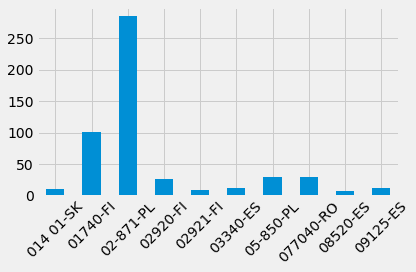

In [37]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

ax = (outDeg
      .toPandas()
      .head(10)
      .plot(kind='bar', x='id', y='outDegree', legend=None))

ax.xaxis.set_label_text("")
#plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
outDeg.join(graph.vertices,"id").orderBy(desc("outDegree"),asc("id")).limit(5).toPandas()

,id,outDegree
0,76220-FR,541
1,70499-DE,489
2,22525-DE,465
3,70439-DE,358
4,48720-DE,325


#### Which are the stations where most of the trips get to?

In [39]:
inDeg = subgraph.inDegrees
inDeg.orderBy(desc("inDegree"),asc("id")).limit(5).toPandas()

,id,inDegree
0,70439-DE,52
1,8048-CH,43
2,6700-AT,42
3,20068-IT,40
4,6060-CH,39


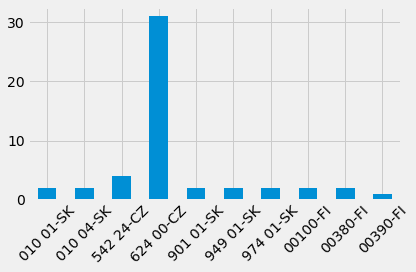

In [40]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

ax = (inDeg
      .toPandas()
      .head(10)
      .plot(kind='bar', x='id', y='inDegree', legend=None))

ax.xaxis.set_label_text("")
#plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
inDeg.join(subgraph.vertices,"id").orderBy(desc("inDegree"),asc("id")).limit(5).toPandas()

,id,inDegree


#### which are the most relevant stations?
We are going to apply the Page Ranks algorithm

In [21]:
ranks = subgraph.pageRank(resetProbability=0.15, maxIter=10)

The algorithm returns a GraphFrame. <br/>
Notice we now have a new column in the vertices DataFrame called **pagerank**

In [22]:
ranks.vertices.limit(5).toPandas()

,id,pagerank


Notice we now have a new column in the edges DataFrame called **weight**

In [23]:
ranks.edges.limit(5).toPandas()

,src,dst,ctry,trip_count,Distance_avg,C02Emission_avg,weight


The most relevant bike station is:

In [24]:
ranks.vertices.orderBy(desc("pagerank")).limit(1).toPandas()

,id,pagerank


<a id='3.1'></a>
### 3.1 Stop Hadoop

Stops Hadoop
Open a terminal and execute
```sh
hadoop-stop.sh
```